In [34]:
import numpy as np
import numpy.random as nprnd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from keras.layers import Input, merge
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils


In [43]:
N = 300
M = 20000
PERCENTILE_RANGE = np.arange(0, 101)
NN_WIDTH = 500
NUM_EPOCHS = 1000

In [44]:
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))


def myGenerator():
    
    while 1:
        sigma = 10.0 * nprnd.rand()
        print("\nTraining sigma=" + str(sigma))

        Z1 = nprnd.normal(0, sigma, (N, M))
        Z2 = nprnd.normal(0, sigma, (N, M))

        # H0 model parameter estimation under H0:
        muH0 = np.mean(np.concatenate([Z1, Z2], axis=0), axis=0)
        sigmaH0 = np.sqrt(np.var(np.concatenate([Z1, Z2], axis=0), axis=0))
        # H1 model parameter estimation under H0:
        muZ1H1 = np.mean(Z1, axis=0)
        muZ2H1 = np.mean(Z2, axis=0)
        sigmaZ1H1 = np.sqrt(np.var(Z1, axis=0))
        sigmaZ2H1 = np.sqrt(np.var(Z2, axis=0))

        TZ = np.sum(
            stats.norm.logpdf(Z1, loc=muZ1H1, scale=sigmaZ1H1) + stats.norm.logpdf(Z2, loc=muZ2H1, scale=sigmaZ2H1)
            - stats.norm.logpdf(Z1, loc=muH0, scale=sigmaH0) - stats.norm.logpdf(Z2, loc=muH0, scale=sigmaH0), axis=0)
        percentileH0 = np.percentile(TZ, PERCENTILE_RANGE)
        ecdfH0 = interp1d(percentileH0, PERCENTILE_RANGE, fill_value=(0.0, 100.0), bounds_error=False)
        p1 = np.sum(ecdfH0(TZ) <= 5) / M

        # for mu in mu_vec:
        #    print("\nTraining mu=" + str(mu))
        h_vec = (nprnd.rand(1, M) > 0.5)
        sign_vec = 2*(nprnd.rand(1, M) > 0.5)-1
        mu_vec = 1 * sigma * nprnd.rand(1, M) * h_vec  * sign_vec

        X = nprnd.normal(0, sigma, (N, M))
        Y = nprnd.normal(0, sigma, (N, M)) + mu_vec

        # H0 model parameter estimation under H0:
        muXYH0 = np.mean(np.concatenate([X, Y], axis=0), axis=0)
        sigmaXYH0 = np.sqrt(np.var(np.concatenate([X, Y], axis=0), axis=0))
        # H1 model parameter estimation under H0:
        muXH1 = np.mean(X, axis=0)
        muYH1 = np.mean(Y, axis=0)
        sigmaXH1 = np.sqrt(np.var(X, axis=0))
        sigmaYH1 = np.sqrt(np.var(Y, axis=0))

        TXY = np.sum(
            stats.norm.logpdf(X, loc=muXH1, scale=sigmaXH1) + stats.norm.logpdf(Y, loc=muYH1, scale=sigmaYH1) -
            stats.norm.logpdf(X, loc=muXYH0, scale=sigmaXYH0) - stats.norm.logpdf(Y, loc=muXYH0, scale=sigmaXYH0),
            axis=0)
        pValues = 100 - ecdfH0(TXY)
        pValues = pValues.reshape((pValues.shape[0],1))

        Xtrain = np.concatenate((X.transpose(), Y.transpose()), axis=1)
        Xtrain -= Xtrain.min(axis=1).reshape((Xtrain.shape[0],1))
        Xtrain /= Xtrain.max(axis=1).reshape((Xtrain.shape[0],1))
        yield (Xtrain, {'main_output': pValues, 'hypothesis': h_vec.transpose() } )


In [45]:
def get_nn_model(input_size):

    main_input = Input(shape=(input_size,), name='main_input')

    #x = Reshape((input_size, 1))(main_input)
    #x = Convolution1D(nb_filter=64, filter_length=3, subsample_length=1, activation='relu')(x)
    #x = Convolution1D(nb_filter=128, filter_length=3, subsample_length=1, activation='relu')(x)
    #x = Convolution1D(nb_filter=128, filter_length=3, subsample_length=1, activation='relu')(x)
    #x = Flatten()(x)

    x = Dense(NN_WIDTH, activation='relu')(main_input)
    x = Dense(NN_WIDTH, activation='relu')(x)
    x = Dense(NN_WIDTH, activation='relu')(x)
    x = Dense(NN_WIDTH, activation='relu')(x)
    x = Dense(NN_WIDTH, activation='relu')(x)
    x = Dense(NN_WIDTH, activation='relu')(x)

    main_output = Dense(1, activation='relu', name='main_output')(x)

    model = Model(inputs=[main_input], outputs=[main_output])
    model.compile(optimizer='adam',
                  loss={'main_output': 'mean_squared_error'},
                  metrics={'main_output': "mean_squared_error"})
    return model

In [46]:
gaussianGenerator = myGenerator()
model = get_nn_model(2*N)

In [47]:
model.fit_generator(gaussianGenerator, steps_per_epoch=1, nb_epoch=NUM_EPOCHS, verbose=1, nb_worker=1)
model.save('model.hdf5')

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1, verbose=1, epochs=1000, workers=1)`
  if __name__ == '__main__':



Training sigma=3.5698226692956982Epoch 1/1000


Training sigma=1.2670505284499511
1/1 [==============================] - 8s - loss: 1852.6331 - mean_squared_error: 1852.6313
Epoch 2/1000

Training sigma=1.8893342851276584
1/1 [==============================] - 7s - loss: 1775.6158 - mean_squared_error: 1775.6145
Epoch 3/1000

Training sigma=7.8306674508806005
1/1 [==============================] - 8s - loss: 1556.0691 - mean_squared_error: 1556.0681
Epoch 4/1000

Training sigma=6.618693476387014
1/1 [==============================] - 8s - loss: 1193.9531 - mean_squared_error: 1193.9524
Epoch 5/1000

Training sigma=8.510099097790912
1/1 [==============================] - 8s - loss: 1405.4430 - mean_squared_error: 1405.4420
Epoch 6/1000

Training sigma=8.571275177393687
1/1 [==============================] - 8s - loss: 1102.2598 - mean_squared_error: 1102.2590
Epoch 7/1000

Training sigma=6.316970017063015
1/1 [==============================] - 7s - loss: 1096.7997 - mean_squared_error:


Training sigma=1.1299001118350593


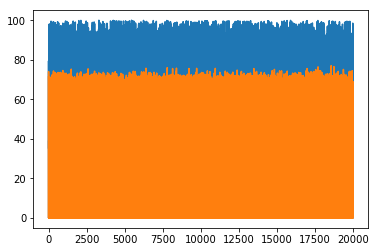

Power ttest:  0.820013967874
Power NN-test:  0.834780005986
False alarm ttest:  0.0508168788213
False alarm NN-test:  0.0508168788213


In [53]:
X = gaussianGenerator.__next__()
yPred = model.predict(X[0])

plt.plot(X[1]['main_output'])
plt.plot(yPred)
plt.show()

TH = 5
THnn = 10
power_ttest = np.sum( np.multiply(X[1]['main_output'] < TH, X[1]['hypothesis'] == 1) ) / np.sum( X[1]['hypothesis'])
power_nntest = np.sum( np.multiply(yPred < THnn, X[1]['hypothesis'] == 1) ) / np.sum( X[1]['hypothesis'])

fa_ttest = np.sum( np.multiply(X[1]['main_output'] < TH, X[1]['hypothesis'] == 0) ) / np.sum( X[1]['hypothesis'] == 0)
fa_nntest = np.sum( np.multiply(yPred < THnn, X[1]['hypothesis'] == 0) ) / np.sum( X[1]['hypothesis'] == 0)

print('Power ttest: ', power_ttest)
print('Power NN-test: ', power_nntest)
print('False alarm ttest: ', fa_ttest)
print('False alarm NN-test: ', fa_nntest)
